## 🌟 1. Project Idea

In this project, we are working on a path planning problem for a robot on a 15x15 grid.  

🎯 *Objective: Move from a defined **start point* to a *goal point*, while:
- ✅ Collecting predefined *items*
- 🚫 Avoiding *obstacles*

To achieve this, we implemented and compared the performance of *three bio-inspired optimization algorithms*:
- 🐜 *Ant Colony Optimization (ACO)*
- 🐝 *Artificial Bee Colony (ABC)*
- 🐦 *Particle Swarm Optimization (PSO)*

The goal is to find the most efficient and intelligent path for the robot.


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import deque
from copy import deepcopy

## 🧱 Grid and Problem Setup

We use a 20x20 grid where:
- 0 represents free space
- 1 represents obstacles
- Special cells contain *items to be collected* 🧩

In [ ]:
def create_grid(grid_size, num_obstacles, start, goal):
    grid = np.zeros((grid_size, grid_size), dtype=int)
    obstacles = set()

    while len(obstacles) < num_obstacles:
        x, y = random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        if (x, y) not in {start, goal}:
            obstacles.add((x, y))
            grid[x][y] = 1
    return grid

### 🔍 BFS with Random Exploration

This function finds a path from the *start* to the *goal* using *Breadth-First Search, exploring neighbors in a random order*.

#### 🔧 How It Works:
- Starts from the initial position.
- Explores all valid neighboring cells using a queue.
- Randomizes neighbor order to introduce variety.
- Stops when the goal is reached.

#### 📦 Returns:
- A list of positions from start to goal.
- None if no path is found.

> 🚀 Useful for generating diverse paths in ABC and PSO algorithms.


In [ ]:
def bfs_path(grid, start, goal):
    """BFS with random exploration"""
    visited = set()
    queue = deque([[start]])

    while queue:
        path = queue.popleft()
        current = path[-1]

        if current == goal:
            return path

        neighbors = []
        for dx, dy in random.sample([(0,1), (1,0), (0,-1), (-1,0)], 4):
            neighbor = (current[0]+dx, current[1]+dy)
            if is_valid(grid, neighbor) and neighbor not in visited:
                neighbors.append(neighbor)

        for neighbor in neighbors:
            visited.add(neighbor)
            new_path = list(path)
            new_path.append(neighbor)
            queue.append(new_path)

    return None


### 🎯 add_items Function (Summary)

Places a set number of items on the grid while making sure:
- They don’t block the start or goal.
- Each item can be reached from the start and can reach the goal.

In [ ]:
def add_items(grid, start, goal, num_items=5):
    """Add items with guaranteed accessibility"""
    items = set()
    while len(items) < num_items:
        x, y = random.randint(0, grid.shape[0]-1), random.randint(0, grid.shape[1]-1)
        pos = (x, y)
        if (grid[x][y] == 0 and pos not in {start, goal} and
            bfs_path(grid, start, pos) and bfs_path(grid, pos, goal)):
            items.add(pos)
    return items


## 🧠 2. How We Applied ACO, ABC & PSO in Our Grid

Each algorithm was tested on the *same environment* to ensure fairness:
- Same *grid configuration*
- Same *start & goal*
- Same number of *items* and *obstacles*

🔍 Here's how each algorithm works in our project:


### 🐝 Artificial Bee Colony (ABC)
Bees explore and exploit food sources (paths). Employed bees search locally, while scout bees explore randomly.


---

In [ ]:
def abc_optimizer(grid, start, goal, items, colony_size=30, max_iter=100):
    def generate_candidate(base_path):
        new_path = bfs_path(grid, start, goal) or [start]
        crossover = random.randint(1, min(len(base_path), len(new_path))-1)
        candidate = base_path[:crossover] + new_path[crossover:]
        return [p for p in candidate if is_valid(grid, p)]

    population = [bfs_path(grid, start, goal) or [start] for _ in range(colony_size)]
    best_path = min(population, key=len)

    for _ in range(max_iter):
        # Employed bees phase
        for i in range(colony_size):
            candidate = generate_candidate(population[i])
            if len(candidate) < len(population[i]):
                population[i] = candidate

        # Onlooker bees phase
        fitness = [1/(1+len(p)) for p in population]
        probs = [f/sum(fitness) for f in fitness]
        for _ in range(colony_size):
            i = np.random.choice(len(population), p=probs)
            candidate = generate_candidate(population[i])
            if len(candidate) < len(population[i]):
                population[i] = candidate

        # Scout bees phase
        if random.random() < 0.1:
            idx = random.randint(0, colony_size-1)
            population[idx] = bfs_path(grid, start, goal) or [start]

        # Update best
        current_best = min(population, key=len)
        if len(current_best) < len(best_path):
            best_path = current_best

    return best_path, items_along_path(best_path, items)



    return best_path if best_path else [start], best_items

### 🐜 Ant Colony Optimization (ACO)
Simulates ants leaving pheromone trails. Better paths leave stronger pheromones, guiding others toward optimal paths.


In [ ]:
def aco_optimizer(grid, start, goal, items, ants=30, iterations=100):
    pheromone = np.ones(grid.shape) * 0.1
    best_path = None
    best_items = set()

    for _ in range(iterations):
        paths = []
        for _ in range(ants):
            path = []
            current = start
            visited = set()
            collected = set()

            while current != goal:
                path.append(current)
                visited.add(current)

                if current in items:
                    collected.add(current)

                # Get valid neighbors
                neighbors = []
                for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
                    neighbor = (current[0]+dx, current[1]+dy)
                    if is_valid(grid, neighbor) and neighbor not in visited:
                        neighbors.append(neighbor)

                if not neighbors:
                    break

                # Fixed probability calculation
                indices = list(range(len(neighbors)))
                weights = [pheromone[n] * 1/(1 + distance(n, goal)) for n in neighbors]  # Fixed line
                total = sum(weights)

                if total <= 0:
                    current = random.choice(neighbors)
                else:
                    probs = [w/total for w in weights]
                    selected_idx = np.random.choice(indices, p=probs)
                    current = neighbors[selected_idx]

            if current == goal:
                path.append(goal)
                paths.append((path, collected))
                if len(collected) > len(best_items):
                    best_path = path
                    best_items = collected.copy()

        # Update pheromones
        pheromone *= 0.95
        for path, collected in paths:
            for pos in path:
                pheromone[pos] += 0.1 * (1 + len(collected))

    return best_path if best_path else [start], best_items

### 🐦 Particle Swarm Optimization (PSO)
Particles move in the grid and adjust their directions based on their best path and the global best, mimicking bird flocking behavior.


In [ ]:
def pso_optimizer(grid, start, goal, items, particles=30, iterations=100):
    class Particle:
        def __init__(self):
            self.path = bfs_path(grid, start, goal) or [start]
            self.best_path = self.path.copy()
            self.best_score = self.score()

        def score(self):
            return len(self.path) - 10*len(items_along_path(self.path, items))

        def update(self, global_best):
            crossover = random.randint(1, min(len(self.path), len(global_best))-1)
            new_path = self.path[:crossover] + global_best[crossover:]
            new_path = repair_path(new_path)
            new_score = len(new_path) - 10*len(items_along_path(new_path, items))

            if new_score < self.best_score:
                self.best_path = new_path
                self.best_score = new_score
            self.path = new_path

    def repair_path(path):
        repaired = []
        for pos in path:
            if is_valid(grid, pos) and (not repaired or pos != repaired[-1]):
                repaired.append(pos)
        if repaired and repaired[-1] != goal:
            final = bfs_path(grid, repaired[-1], goal)
            if final:
                repaired += final[1:]
        return repaired

    swarm = [Particle() for _ in range(particles)]
    global_best = min(swarm, key=lambda p: p.best_score).best_path

    for _ in range(iterations):
        for particle in swarm:
            particle.update(global_best)
        current_best = min(swarm, key=lambda p: p.best_score).best_path
        if len(current_best) < len(global_best):
            global_best = current_best

    return global_best, items_along_path(global_best, items)

###Helper Functions for Path Planning
Checks if a position (x, y) is within the grid bounds and not an obstacle.

In [ ]:
def is_valid(grid, pos):
    x, y = pos
    return 0 <= x < grid.shape[0] and 0 <= y < grid.shape[1] and grid[x][y] != 1

def distance(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def items_along_path(path, items):
    return set(pos for pos in path if pos in items)

In [ ]:
def show_initial_grid(grid, start, goal, items):
    plt.figure(figsize=(8, 8))

    # Draw grid
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            plt.fill_between([y, y+1], x, x+1,
                            color='black' if grid[x][y] else 'white', alpha=0.2)

    # Draw items
    item_x = [p[1]+0.5 for p in items]
    item_y = [p[0]+0.5 for p in items]
    plt.scatter(item_x, item_y, marker='*', s=200, color='magenta', label='Items')

    # Start/goal markers
    plt.scatter(start[1]+0.5, start[0]+0.5, marker='o', s=100, color='green', label='Start')
    plt.scatter(goal[1]+0.5, goal[0]+0.5, marker='X', s=100, color='red', label='Goal')

    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title("Initial Grid State")
    plt.show()

In [ ]:
def plot_comparison(grid, paths, items, start, goal):
    plt.figure(figsize=(15, 5))
    titles = ["ABC Path", "ACO Path", "PSO Path"]
    colors = ['gold', 'lime', 'cyan']

    for i, (path, collected) in enumerate(paths):
        plt.subplot(1, 3, i+1)

        # Draw grid
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                plt.fill_between([y, y+1], x, x+1,
                                color='black' if grid[x][y] else 'white', alpha=0.2)

        # Draw path
        px = [p[1]+0.5 for p in path]
        py = [p[0]+0.5 for p in path]
        plt.plot(px, py, color=colors[i], linewidth=2)

        # Draw remaining items
        remaining = items - collected
        ix = [p[1]+0.5 for p in remaining]
        iy = [p[0]+0.5 for p in remaining]
        plt.scatter(ix, iy, marker='*', s=100, color='magenta')

        # Start/goal markers
        plt.scatter(start[1]+0.5, start[0]+0.5, marker='o', s=100, color='green')
        plt.scatter(goal[1]+0.5, goal[0]+0.5, marker='X', s=100, color='red')

        plt.gca().invert_yaxis()
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{titles[i]}\nItems: {len(collected)}/{len(items)}")

    plt.tight_layout()
    plt.show()


In [ ]:
GRID_SIZE = 15
OBSTACLES = 40
START = (0, 0)
GOAL = (GRID_SIZE-1, GRID_SIZE-1)

🧱 Grid Initialization

We begin by generating the environment in which the robot will operate.

In [ ]:
grid = create_grid(GRID_SIZE, OBSTACLES, START, GOAL)
items = add_items(grid, START, GOAL)

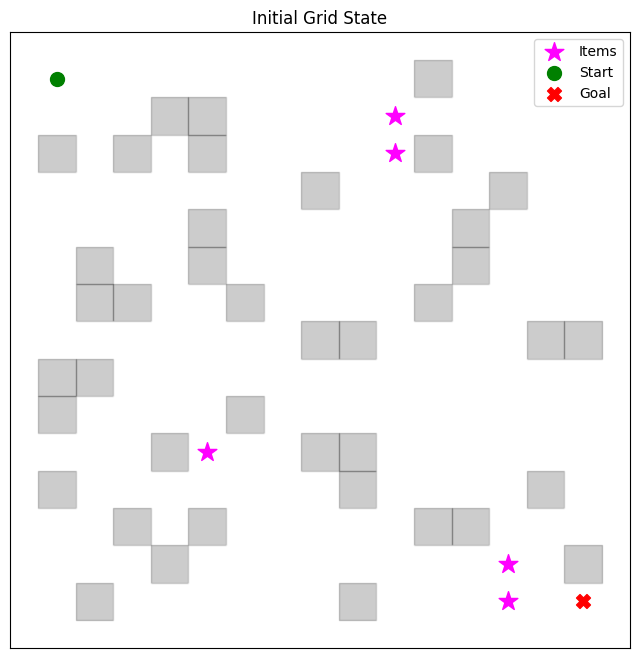

In [ ]:
show_initial_grid(grid, START, GOAL, items)

## 🧪 Running the Algorithms
Each algorithm was run with the same initial setup:
- Grid size: 20x20
- Obstacles: 70 random positions
- Items: 6 randomly placed
- Start point: Defined
- Goal point: Defined

Below are the results and best paths found by each algorithm.

In [ ]:
abc_path, abc_items = abc_optimizer(grid, START, GOAL, items)
aco_path, aco_items = aco_optimizer(grid, START, GOAL, items)
pso_path, pso_items = pso_optimizer(grid, START, GOAL, items)

In [ ]:
results = [
    {"Algorithm": "ABC",
     "Path Length": len(abc_path),
     "Items Collected": f"{len(abc_items)}/{len(items)}",
     "Valid Path": "✅" if abc_path[-1] == GOAL else "❌"},

    {"Algorithm": "ACO",
     "Path Length": len(aco_path),
     "Items Collected": f"{len(aco_items)}/{len(items)}",
     "Valid Path": "✅" if aco_path[-1] == GOAL else "❌"},

    {"Algorithm": "PSO",
     "Path Length": len(pso_path),
     "Items Collected": f"{len(pso_items)}/{len(items)}",
     "Valid Path": "✅" if pso_path[-1] == GOAL else "❌"}
]

## 📊 Results & Visualization

We plotted the best path for each algorithm:

- 🔵 Start point  
- 🟢 Goal point  
- 🟨 Items collected  
- 🔴 Obstacles  
- 🔷 Path taken by the agent

These visualizations help us compare the performance of each method clearly.

| Algorithm   |   Path Length | Items Collected   | Valid Path   |
|-------------|---------------|-------------------|--------------|
| ABC         |            29 | 2/5               | ✅           |
| ACO         |            49 | 4/5               | ✅           |
| PSO         |            29 | 3/5               | ✅           |


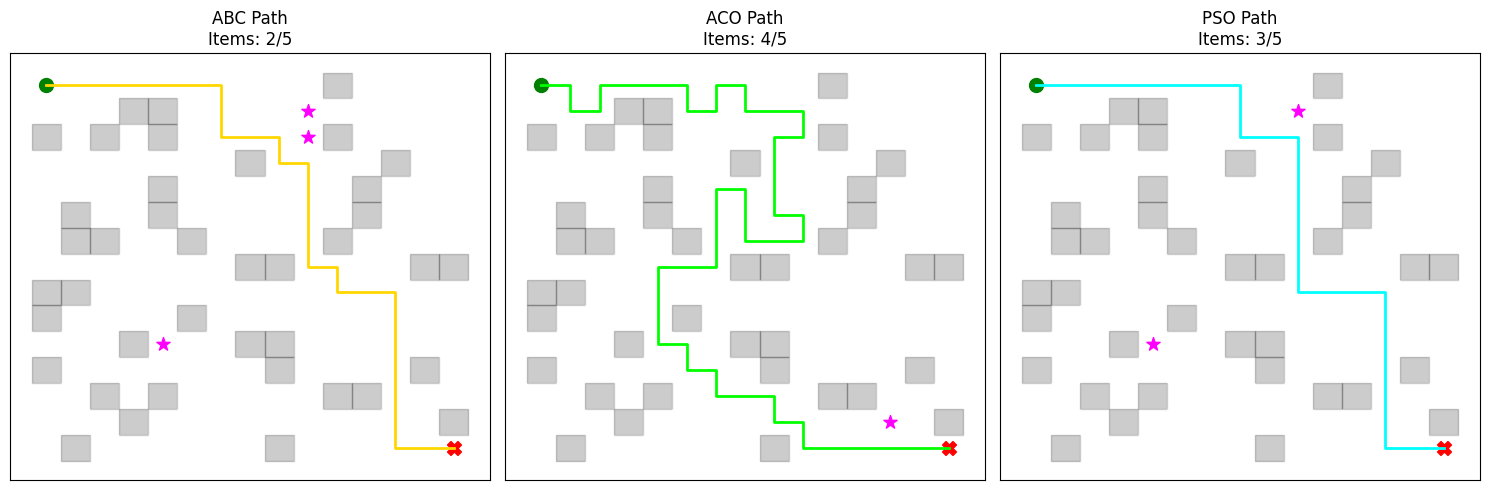

In [ ]:
print(tabulate(results, headers="keys", tablefmt="github"))
plot_comparison(grid,
               [(abc_path, abc_items), (aco_path, aco_items), (pso_path, pso_items)],
               items, START, GOAL)

📝 *Best Performer* : Particle Swarm Optimization (PSO)
It provided the *best balance between efficiency and effectiveness* in our grid scenario.

---